In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.7 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_44c"
DATASET = "fernando2rad/brain-tumor-mri-images-44c"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)


Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
Dataset downloaded to: brain_tumor_44c


In [4]:
from pathlib import Path

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

paths, labels = [], []

# Collect class folders
class_dirs = []
for root, dirs, files in os.walk(DATA_DIR):
    if any(f.lower().endswith(IMAGE_EXTS) for f in files):
        class_dirs.append(root)

class_dirs = sorted(class_dirs)

class_to_idx = {Path(d).name: idx for idx, d in enumerate(class_dirs)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Number of classes:", len(class_to_idx))

for root, _, files in os.walk(DATA_DIR):
    class_name = Path(root).name
    if class_name not in class_to_idx:
        continue

    label = class_to_idx[class_name]

    for f in files:
        if f.lower().endswith(IMAGE_EXTS):
            paths.append(os.path.join(root, f))
            labels.append(label)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print("Total images:", len(df))
print("Class distribution:\n", df["label"].value_counts().sort_index())

num_classes = df["label"].nunique()


Number of classes: 44
Total images: 4478
Class distribution:
 label
0     176
1     232
2     171
3      66
4     112
5      73
6      45
7      48
8      57
9      20
10     18
11     23
12     27
13     40
14     33
15     55
16     94
17     55
18     30
19     31
20     17
21     23
22     67
23     41
24    272
25    369
26    233
27    130
28    223
29    104
30     86
31     72
32     66
33     66
34    108
35     63
36    148
37    194
38    123
39     28
40     84
41     33
42    251
43    271
Name: count, dtype: int64


In [5]:
train_df, test_df = train_test_split(
    df, stratify=df.label, test_size=0.2, random_state=42
)

train_df, val_df = train_test_split(
    train_df, stratify=train_df.label, test_size=0.2, random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2865
Val: 717
Test: 896


In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label


In [13]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # 224 is fine for base
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [14]:
train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16,
    num_workers=2
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16,
    num_workers=2
)


In [15]:
import timm

model = timm.create_model(
    "inception_v3",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)

print("InceptionV3 model loaded successfully")

summary(model, input_size=(1,3,299,299))



InceptionV3 model loaded successfully


Layer (type:depth-idx)                   Output Shape              Param #
InceptionV3                              [1, 44]                   --
├─ConvNormAct: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNormAct2d: 2-2               [1, 32, 149, 149]         64
│    │    └─Identity: 3-1                [1, 32, 149, 149]         --
│    │    └─ReLU: 3-2                    [1, 32, 149, 149]         --
├─ConvNormAct: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNormAct2d: 2-4               [1, 32, 147, 147]         64
│    │    └─Identity: 3-3                [1, 32, 147, 147]         --
│    │    └─ReLU: 3-4                    [1, 32, 147, 147]         --
├─ConvNormAct: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [17]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [18]:
from PIL import Image


In [19]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n===== Epoch {epoch+1} TRAIN =====")
    print(f"Loss: {train_loss:.4f}")
    print(f"Acc: {train_out['acc']:.4f} | Prec: {train_out['precision']:.4f} | "
          f"Recall: {train_out['recall']:.4f} | F1: {train_out['f1']:.4f}")
    print(f"Spec: {train_spec:.4f} | Sens: {train_sens:.4f} | "
          f"MCC: {train_out['mcc']:.4f} | AUC: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"\n===== Epoch {epoch+1} VALID =====")
    print(f"Loss: {val_loss:.4f}")
    print(f"Acc: {val_out['acc']:.4f} | Prec: {val_out['precision']:.4f} | "
          f"Recall: {val_out['recall']:.4f} | F1: {val_out['f1']:.4f}")
    print(f"Spec: {val_spec:.4f} | Sens: {val_sens:.4f} | "
          f"MCC: {val_out['mcc']:.4f} | AUC: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    # ================= SAVE HISTORY =================
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    # ================= EARLY STOPPING =================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_inceptionv3_44c.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training - Epoch [1/30]: 100%|██████████| 180/180 [00:51<00:00,  3.51it/s]



===== Epoch 1 TRAIN =====
Loss: 1.8253
Acc: 0.3922 | Prec: 0.4785 | Recall: 0.3922 | F1: 0.4120
Spec: 0.9889 | Sens: 0.3922 | MCC: 0.5112 | AUC: 0.9099


Validating: 100%|██████████| 45/45 [00:06<00:00,  6.44it/s]



===== Epoch 1 VALID =====
Loss: 1.1543
Acc: 0.5683 | Prec: 0.6401 | Recall: 0.5683 | F1: 0.5692
Spec: 0.9928 | Sens: 0.5683 | MCC: 0.6830 | AUC: 0.9707
Current LR: 5.000000e-04



Training - Epoch [2/30]: 100%|██████████| 180/180 [00:51<00:00,  3.51it/s]



===== Epoch 2 TRAIN =====
Loss: 0.8762
Acc: 0.6475 | Prec: 0.7157 | Recall: 0.6475 | F1: 0.6726
Spec: 0.9940 | Sens: 0.6475 | MCC: 0.7364 | AUC: 0.9849


Validating: 100%|██████████| 45/45 [00:04<00:00,  9.03it/s]



===== Epoch 2 VALID =====
Loss: 1.2073
Acc: 0.6224 | Prec: 0.7196 | Recall: 0.6224 | F1: 0.6166
Spec: 0.9922 | Sens: 0.6224 | MCC: 0.6616 | AUC: 0.9836
Current LR: 4.986305e-04



Training - Epoch [3/30]: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]



===== Epoch 3 TRAIN =====
Loss: 0.5032
Acc: 0.8004 | Prec: 0.8317 | Recall: 0.8004 | F1: 0.8124
Spec: 0.9968 | Sens: 0.8004 | MCC: 0.8573 | AUC: 0.9941


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.96it/s]



===== Epoch 3 VALID =====
Loss: 0.7108
Acc: 0.7831 | Prec: 0.8119 | Recall: 0.7831 | F1: 0.7746
Spec: 0.9957 | Sens: 0.7831 | MCC: 0.8095 | AUC: 0.9918
Current LR: 4.945369e-04



Training - Epoch [4/30]: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]



===== Epoch 4 TRAIN =====
Loss: 0.2902
Acc: 0.8869 | Prec: 0.9025 | Recall: 0.8869 | F1: 0.8933
Spec: 0.9981 | Sens: 0.8869 | MCC: 0.9165 | AUC: 0.9985


Validating: 100%|██████████| 45/45 [00:06<00:00,  7.50it/s]



===== Epoch 4 VALID =====
Loss: 0.7218
Acc: 0.7556 | Prec: 0.7530 | Recall: 0.7556 | F1: 0.7251
Spec: 0.9954 | Sens: 0.7556 | MCC: 0.7957 | AUC: 0.9925
Current LR: 4.877641e-04



Training - Epoch [5/30]: 100%|██████████| 180/180 [00:49<00:00,  3.67it/s]



===== Epoch 5 TRAIN =====
Loss: 0.3209
Acc: 0.8763 | Prec: 0.8925 | Recall: 0.8763 | F1: 0.8832
Spec: 0.9978 | Sens: 0.8763 | MCC: 0.9020 | AUC: 0.9985


Validating: 100%|██████████| 45/45 [00:04<00:00,  9.15it/s]



===== Epoch 5 VALID =====
Loss: 0.8942
Acc: 0.7632 | Prec: 0.8022 | Recall: 0.7632 | F1: 0.7326
Spec: 0.9951 | Sens: 0.7632 | MCC: 0.7864 | AUC: 0.9873
Current LR: 4.783864e-04



Training - Epoch [6/30]: 100%|██████████| 180/180 [00:48<00:00,  3.72it/s]



===== Epoch 6 TRAIN =====
Loss: 0.2056
Acc: 0.9217 | Prec: 0.9353 | Recall: 0.9217 | F1: 0.9276
Spec: 0.9987 | Sens: 0.9217 | MCC: 0.9412 | AUC: 0.9993


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.75it/s]



===== Epoch 6 VALID =====
Loss: 0.4669
Acc: 0.8445 | Prec: 0.8683 | Recall: 0.8445 | F1: 0.8410
Spec: 0.9974 | Sens: 0.8445 | MCC: 0.8858 | AUC: 0.9972
Current LR: 4.665064e-04



Training - Epoch [7/30]: 100%|██████████| 180/180 [00:48<00:00,  3.71it/s]



===== Epoch 7 TRAIN =====
Loss: 0.1190
Acc: 0.9690 | Prec: 0.9720 | Recall: 0.9690 | F1: 0.9701
Spec: 0.9993 | Sens: 0.9690 | MCC: 0.9706 | AUC: 0.9998


Validating: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]



===== Epoch 7 VALID =====
Loss: 0.3783
Acc: 0.8697 | Prec: 0.8924 | Recall: 0.8697 | F1: 0.8715
Spec: 0.9977 | Sens: 0.8697 | MCC: 0.8974 | AUC: 0.9980
Current LR: 4.522542e-04



Training - Epoch [8/30]: 100%|██████████| 180/180 [00:48<00:00,  3.72it/s]



===== Epoch 8 TRAIN =====
Loss: 0.1299
Acc: 0.9679 | Prec: 0.9766 | Recall: 0.9679 | F1: 0.9719
Spec: 0.9993 | Sens: 0.9679 | MCC: 0.9695 | AUC: 0.9997


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.43it/s]



===== Epoch 8 VALID =====
Loss: 0.3937
Acc: 0.8784 | Prec: 0.8880 | Recall: 0.8784 | F1: 0.8733
Spec: 0.9977 | Sens: 0.8784 | MCC: 0.8987 | AUC: 0.9953
Current LR: 4.357862e-04



Training - Epoch [9/30]: 100%|██████████| 180/180 [00:48<00:00,  3.70it/s]



===== Epoch 9 TRAIN =====
Loss: 0.1036
Acc: 0.9792 | Prec: 0.9792 | Recall: 0.9792 | F1: 0.9790
Spec: 0.9995 | Sens: 0.9792 | MCC: 0.9775 | AUC: 0.9998


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.88it/s]



===== Epoch 9 VALID =====
Loss: 0.5365
Acc: 0.8316 | Prec: 0.8937 | Recall: 0.8316 | F1: 0.8430
Spec: 0.9971 | Sens: 0.8316 | MCC: 0.8729 | AUC: 0.9949
Current LR: 4.172827e-04



Training - Epoch [10/30]: 100%|██████████| 180/180 [00:48<00:00,  3.72it/s]



===== Epoch 10 TRAIN =====
Loss: 0.0922
Acc: 0.9772 | Prec: 0.9798 | Recall: 0.9772 | F1: 0.9783
Spec: 0.9995 | Sens: 0.9772 | MCC: 0.9775 | AUC: 0.9999


Validating: 100%|██████████| 45/45 [00:05<00:00,  7.70it/s]



===== Epoch 10 VALID =====
Loss: 0.4668
Acc: 0.8444 | Prec: 0.8875 | Recall: 0.8444 | F1: 0.8453
Spec: 0.9974 | Sens: 0.8444 | MCC: 0.8873 | AUC: 0.9962
Current LR: 3.969463e-04



Training - Epoch [11/30]: 100%|██████████| 180/180 [00:48<00:00,  3.71it/s]



===== Epoch 11 TRAIN =====
Loss: 0.1001
Acc: 0.9760 | Prec: 0.9804 | Recall: 0.9760 | F1: 0.9779
Spec: 0.9995 | Sens: 0.9760 | MCC: 0.9779 | AUC: 0.9999


Validating: 100%|██████████| 45/45 [00:06<00:00,  7.48it/s]



===== Epoch 11 VALID =====
Loss: 0.4710
Acc: 0.8965 | Prec: 0.9000 | Recall: 0.8965 | F1: 0.8909
Spec: 0.9979 | Sens: 0.8965 | MCC: 0.9062 | AUC: 0.9933
Current LR: 3.750000e-04



Training - Epoch [12/30]: 100%|██████████| 180/180 [00:48<00:00,  3.73it/s]



===== Epoch 12 TRAIN =====
Loss: 0.0711
Acc: 0.9878 | Prec: 0.9867 | Recall: 0.9878 | F1: 0.9872
Spec: 0.9997 | Sens: 0.9878 | MCC: 0.9855 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.91it/s]


===== Epoch 12 VALID =====
Loss: 0.3786
Acc: 0.9033 | Prec: 0.9003 | Recall: 0.9033 | F1: 0.8919
Spec: 0.9979 | Sens: 0.9033 | MCC: 0.9090 | AUC: 0.9982
Current LR: 3.516842e-04

Early stopping triggered.


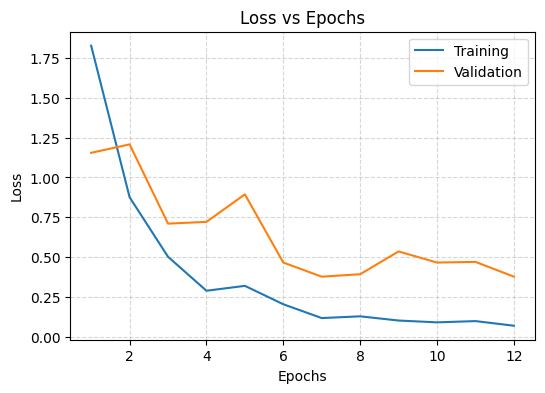

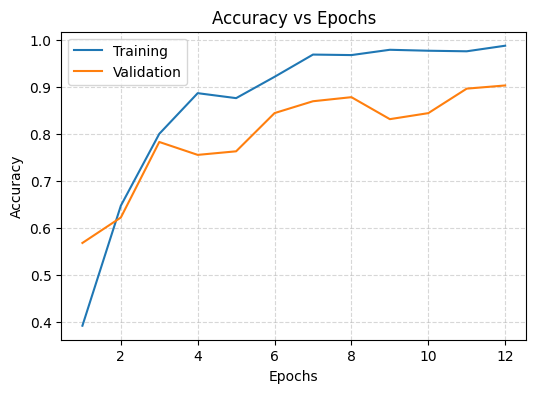

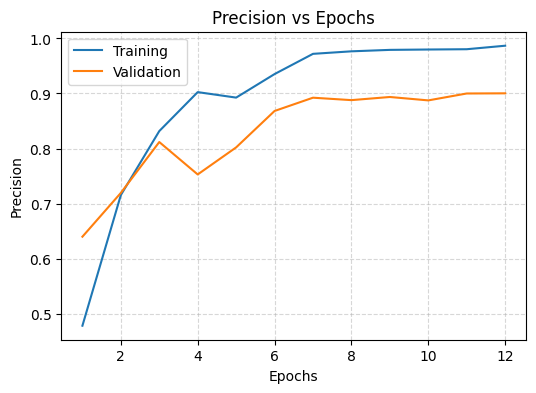

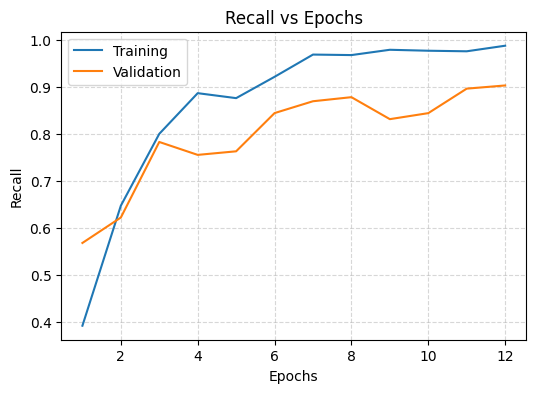

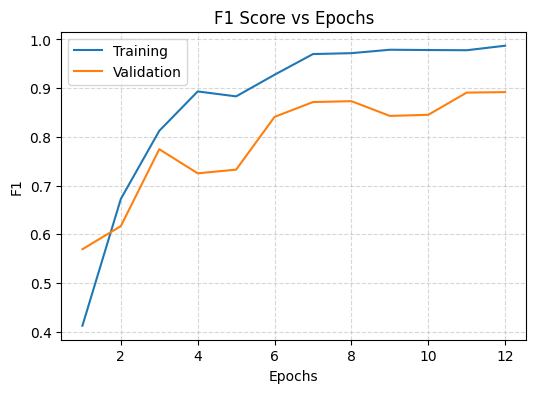

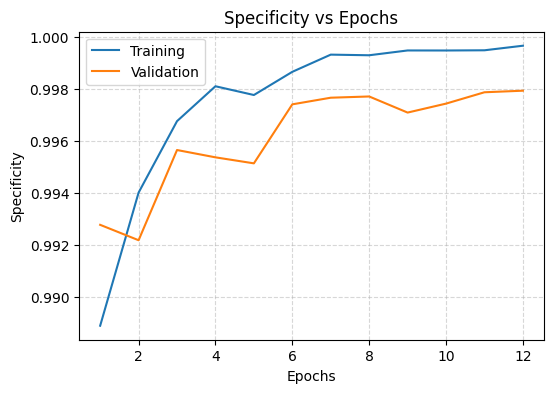

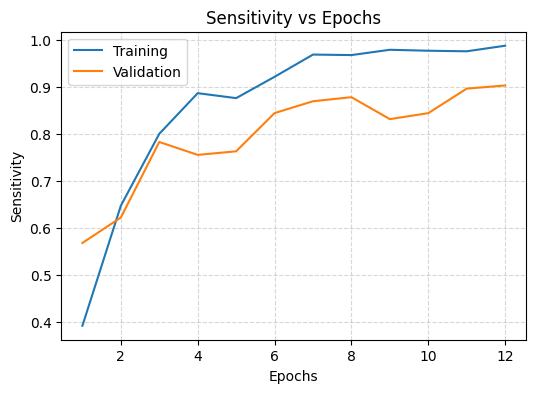

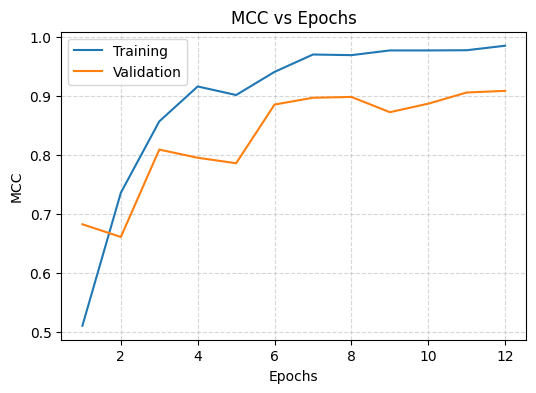

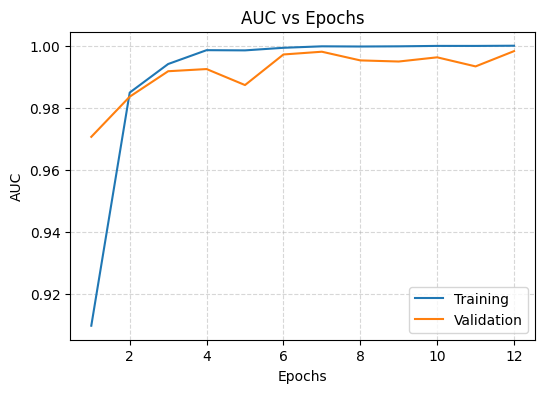

In [20]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [21]:
if os.path.exists("best_inceptionv3_44c.pth"):
    model.load_state_dict(torch.load("best_inceptionv3_44c.pth"))
    print("Best model loaded.")
else:
    print("No saved model found.")


Best model loaded.


In [22]:
# Load best model
model.load_state_dict(torch.load("best_inceptionv3_44c.pth"))

model.eval()


InceptionV3(
  (Conv2d_1a_3x3): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2a_3x3): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2b_3x3): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size

In [23]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 56/56 [00:07<00:00,  7.68it/s]


===== TEST RESULTS =====
Test Loss: 0.3365
ACC: 0.8533
PRECISION: 0.8924
RECALL: 0.8533
F1: 0.8585
AUC: 0.9981
MCC: 0.9028


In [24]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.8919    0.9429    0.9167        35
           1     0.8519    1.0000    0.9200        46
           2     0.9333    0.8235    0.8750        34
           3     0.9231    0.9231    0.9231        13
           4     0.9565    1.0000    0.9778        22
           5     0.9333    0.9333    0.9333        15
           6     1.0000    0.5556    0.7143         9
           7     0.6923    0.9000    0.7826        10
           8     0.8333    0.9091    0.8696        11
           9     0.8000    1.0000    0.8889         4
          10     1.0000    0.6667    0.8000         3
          11     0.0000    0.0000    0.0000         5
          12     0.5556    1.0000    0.7143         5
          13     0.7500    0.7500    0.7500         8
          14     1.0000    0.7143    0.8333         7
          15     1.0000    0.5455    0.7059        11
          16     1.0000    0.9474    0.9730  

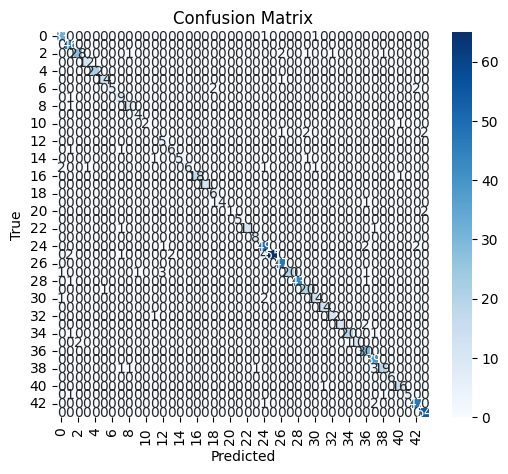

In [25]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [26]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


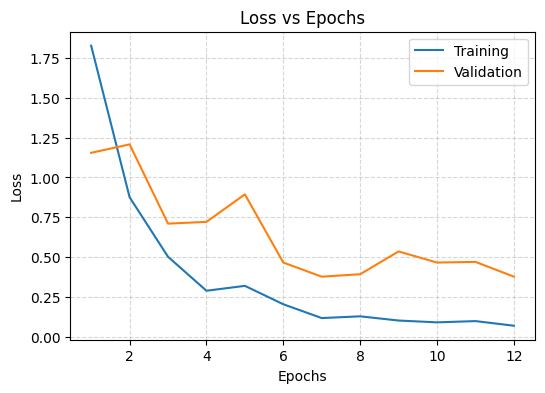

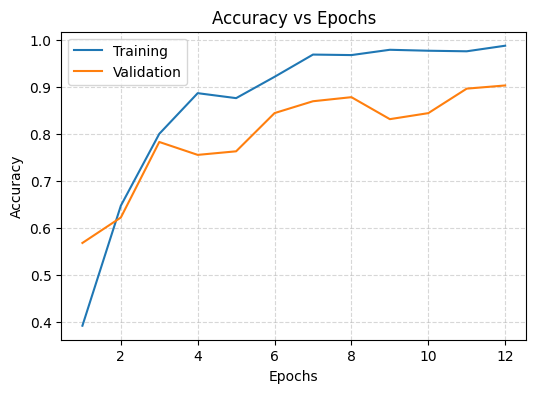

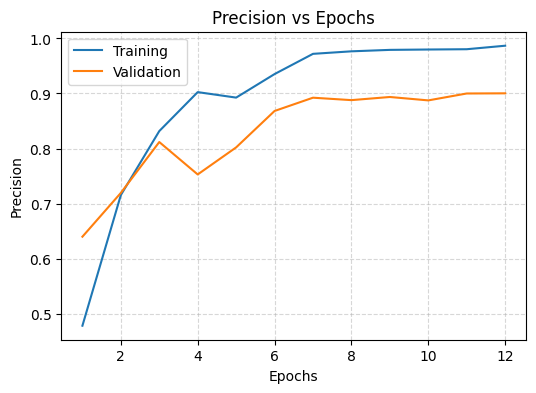

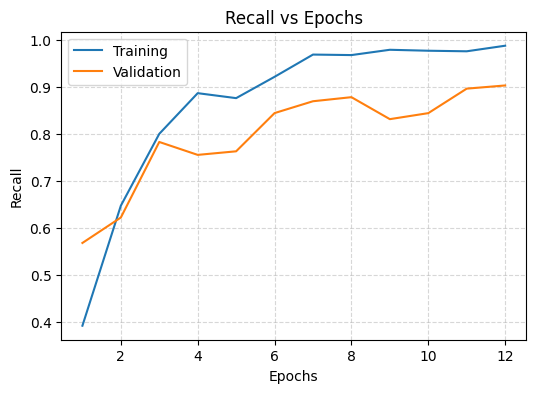

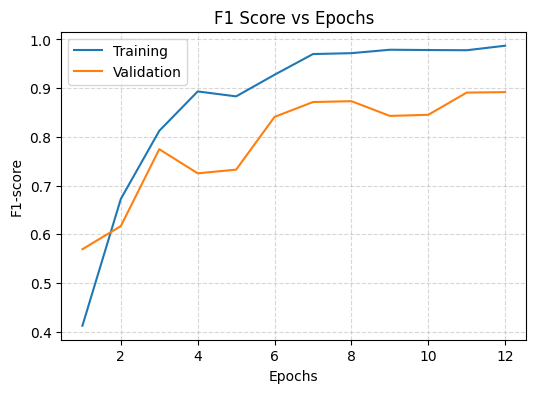

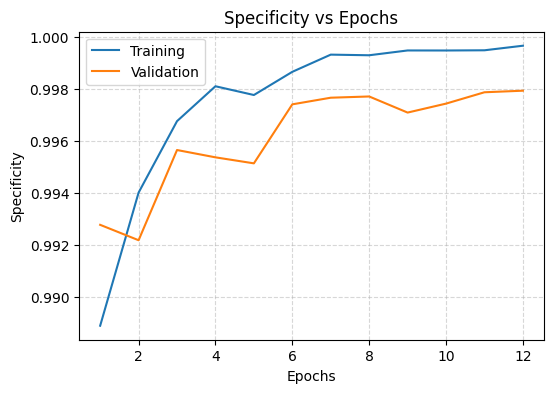

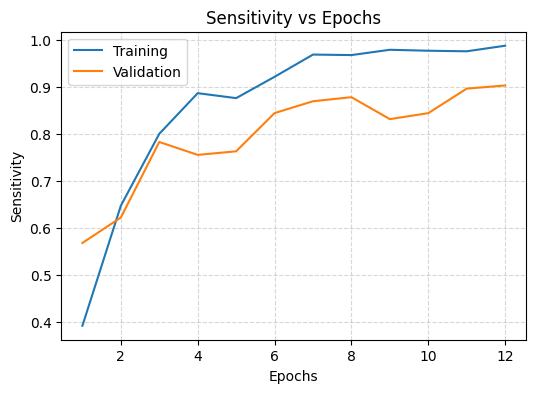

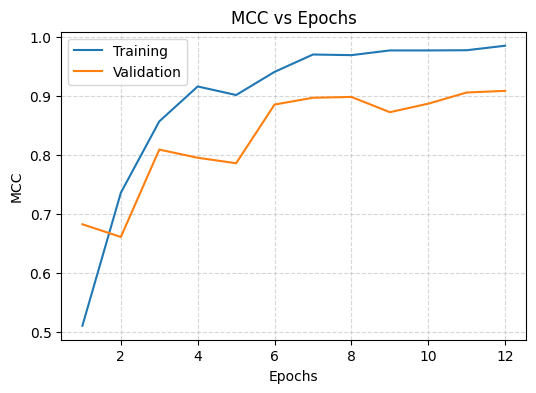

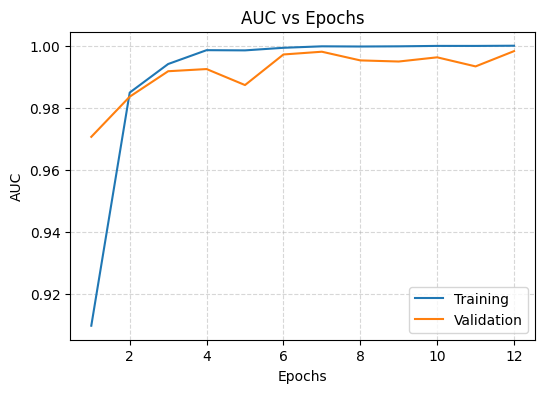

In [27]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
